In [48]:
import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import time

### Prepare Data

In [49]:
# simple tokenization by characters
def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])


lines = open('./data/Shakespeare.txt', 'r').read()
vocab = sorted(list(set(lines)))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}
dataset = torch.tensor(encode(lines), dtype=torch.int8)
print(f'Sentences: {dataset.shape[0]}')

MASTER_CONFIG = {
    "vocab_size": len(vocab),
}

def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    if split == 'train':
        batch_data = train
    elif split == 'test':
        batch_data = test
    else:
        batch_data = val

    # pick random starting points
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y

Sentences: 1115394


### Support Functions

In [50]:
@torch.no_grad()  # don't compute gradients for this function
def evaluate_loss(model, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    losses = []
    start_time = time.time()
    for epoch in range(config['epochs']):
        optimizer.zero_grad()

        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
        logits, loss = model(xs, targets=ys)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        if epoch % config['log_interval'] == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())

    # print(pd.DataFrame(losses))
    print("validation loss: ", losses[-1]['val'])
    return pd.DataFrame(losses).plot()

def generate(model, config=MASTER_CONFIG, max_new_tokens=30):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        # call the model
        logits = model(idx[:, -config['context_window']:])
        # logits = model(idx[:, -1:])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    
    return [decode(x) for x in idx.tolist()]

### Define Models

In [51]:
def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
    for position in range(context_window):
        for i in range(embedding_dim//2):
            theta = 10000. ** (-2.*(i - 1) / embedding_dim)
            m_theta = position * theta
            R[position, 2*i,2*i] = np.cos(m_theta)
            R[position, 2*i,2*i+1] = - np.sin(m_theta)
            R[position, 2*i+1,2*i] = np.sin(m_theta)
            R[position, 2*i+1,2*i+1] = np.cos(m_theta)
    return R
    
class RoPEAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R

    def forward(self, x, return_attn_weights=False):
        b, m, d = x.shape
        
        if 'inference' in self.config and self.config['inference']:  # implement KV cache
            self.q = self.w_q(x[:, -1, :])
            if self.k is not None:
                self.k = torch.concat(self.k[:, -1, :], self.w_k(x[:, -1, :]), dim = -1)
                self.v = torch.concat(self.v[:, -1, :], self.w_v(x[:, -1, :]), dim = -1)
            else:
                self.k = self.w_k(x)
                self.v = self.w_v(x)
        else:
            q = self.w_q(x)
            k = self.w_k(x)
            v = self.w_v(x)

        q_rotated = (torch.bmm(q.transpose(0,1), self.R[:m])).transpose(0,1)
        k_rotated = (torch.bmm(k.transpose(0,1), self.R[:m])).transpose(0,1)

        activations = F.scaled_dot_product_attention(
            q_rotated, k_rotated, v, dropout_p =.1, is_causal=True
        )
        

        if return_attn_weights:
            attn_mask = torch.tril(torch.ones((m,m)), diagonal=0)
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1,2)) / np.sqrt(d) + attn_mask
            # print(torch.exp(attn_weights[1][0])/torch.exp(attn_weights[1][0]).sum())
            attn_weights = F.softmax(attn_weights, dim=-1)
            # print(attn_weights[1][0])
            return activations, attn_weights
        return activations


class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([
            RoPEAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])
        self.dropout = nn.Dropout(.1)

    def forward(self, x):
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x

In [52]:
A=torch.zeros((2,1,5))
B=torch.ones((2,40,5))

torch.matmul(A, B.transpose(1,2)).shape

torch.Size([2, 1, 40])

In [53]:
from collections import OrderedDict

class SwiGLU(nn.Module):
    """
    Swish-Gated Linear Unit
    https://arxiv.org/pdf/2002.05202v1.pdf
    """
    def __init__(self, size):
        super().__init__()
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        # self.beta = torch.randn(1, requires_grad=True)

        self.beta = torch.ones(1, requires_grad=True)
        # nn.Parameter(torch.ones(1))
        # self.register_parameter("beta", self.beta)

    def forward(self, x): 
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()
        # self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))
        self.scale = nn.Parameter(torch.ones(layer_shape))

    def forward(self, x):
        """
        assumes shape is (batch, seq_len, d_model)
        """
        # frob norm is not the same as RMS. RMS = 1/sqrt(N) * frob norm
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw # todo: self.scale[:x.shape[1], :] -> self.scale

class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.rms = RMSNorm((config['context_window'], config['d_model']))

        self.attention = RoPEMaskedMultiheadAttention(config)
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

    def forward(self, x):
        x = self.rms(x) # rms pre-normalization
        x = x + self.attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.feedforward(x)
        return x

class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embeddings = nn.Embedding(config['vocab_size'], config['d_model'])
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )

        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embeddings(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits

        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

### Training

model params: 2370241
Epoch 0 | val loss 4.126 | Time 0.104 | ETA in seconds 10.387
Epoch 100 | val loss 2.437 | Time 15.651 | ETA in seconds 1549.487
Epoch 200 | val loss 2.268 | Time 15.158 | ETA in seconds 1485.496
Epoch 300 | val loss 2.198 | Time 14.951 | ETA in seconds 1450.265
Epoch 400 | val loss 2.104 | Time 17.587 | ETA in seconds 1688.362
Epoch 500 | val loss 2.043 | Time 15.564 | ETA in seconds 1478.608
Epoch 600 | val loss 2.031 | Time 14.071 | ETA in seconds 1322.631
Epoch 700 | val loss 2.030 | Time 14.877 | ETA in seconds 1383.580
Epoch 800 | val loss 2.008 | Time 15.674 | ETA in seconds 1441.968
Epoch 900 | val loss 2.006 | Time 14.018 | ETA in seconds 1275.648
Epoch 1000 | val loss 2.002 | Time 15.404 | ETA in seconds 1386.333
Epoch 1100 | val loss 2.011 | Time 14.853 | ETA in seconds 1321.896
Epoch 1200 | val loss 1.921 | Time 16.171 | ETA in seconds 1423.074
Epoch 1300 | val loss 1.966 | Time 13.890 | ETA in seconds 1208.430
Epoch 1400 | val loss 1.911 | Time 14.647

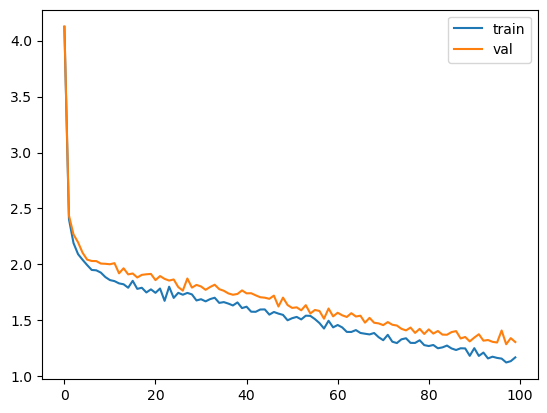

In [54]:
%%time

MASTER_CONFIG.update({
    'epochs': 10000,
    'batch_size': 32,
    'd_model': 128,
    'n_heads': 8,
    'n_layers': 4,
    'context_window': 16,
    "log_interval": 100,
})

llama = Llama(MASTER_CONFIG)
optimizer = torch.optim.Adam(llama.parameters())
train(llama, optimizer, config=MASTER_CONFIG, print_logs=True)

# Save
torch.save({'model_state_dict': llama.state_dict()}, "./checkpoint/llama_kv.pth")

### Generate

In [55]:
# Initialize the model and optimizer
llama_infer = Llama(MASTER_CONFIG)
# optimizer = torch.optim.Adam(llama.parameters())

# Load
checkpoint = torch.load("./checkpoint/llama_kv.pth")
llama_infer.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

print(generate(llama_infer, MASTER_CONFIG, 500)[0])

model params: 2370241

& exe up me oan her fear o'e Strert yrob
Madue,
But'sts one of speak?
Musted hadry, be spay tlemars thy, whickmen, Ritchix brokest
Their hearturs? latich a prouds: your vor pirdoly; robest.

Chat u the do yet your embred rorence?
Provanablyeough eyp is the gaintmarley, baughtion them thee was,
Byot that yield bor the corchyrence,

By that ampries there you coress.

Hen ! carm-but dis or train ssons grait,

Godge, some to ,
He swear thy, the before, I wree. Lordny, le my cotte woes: may that but 
